In [1]:
import numpy as np
import pandas as pd
import os 
inputFolder = '/content/drive/MyDrive/Fer2013_backup/' 
for root, directories, filenames in os.walk(inputFolder): 
    for filename in filenames: print(os.path.join(root,filename))

/content/drive/MyDrive/Fer2013_backup/backUpfer2013.csv
/content/drive/MyDrive/Fer2013_backup/icml_face_data.csv
/content/drive/MyDrive/Fer2013_backup/test.csv
/content/drive/MyDrive/Fer2013_backup/train.csv
/content/drive/MyDrive/Fer2013_backup/checkpoint/best_model_resnet50_modelB2_170false.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/best_model_resnet50_modelD2_170false.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50Scracth_tipe7.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50Scracth_tipe8.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50Scracth_tipe9.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50oriAUGScracthSGD2.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50oriAUGScracthSGD3.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Best_Model_resnet50AUGScracthadam2.h5
/content/drive/MyDrive/Fer2013_backup/checkpoint/Fix_Model_resnet50AUGScracthAdam1sp.h5
/conte

In [2]:
%cd /content/drive/MyDrive/Fer2013_backup/


/content/drive/MyDrive/Fer2013_backup


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
dataread =pd.read_csv('/content/drive/MyDrive/Fer2013_backup/backUpfer2013.csv')
dataread['Usage'].value_counts()
dataread['emotion'].value_counts()

#print(dataread.duplicated().value_counts)
#(df[df.duplicated()])

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [3]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import random

tf.random.set_seed(42)
np.random.seed(42)


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [4]:
#Define the identity block helper function.
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [6]:
def ResNet50(input_shape = (48,48,1), classes = 7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    #X = ZeroPadding2D((1, 1))(X_input)
    X = X_input
    # Stage 1

    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    # removed maxpool
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL . 
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(512, activation = 'relu', name='fc1024' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
"""def ResNet50ori(input_shape = (48, 48, 1), classes = 7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50ori')

    return model"""

In [7]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
 
dataset_path = '/content/drive/MyDrive/Fer2013_backup/backUpfer2013.csv'
image_size=(48,48)

def load_fer2013():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
#xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
#Data Augumentationfgf
"""data_generator = ImageDataGenerator(
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        vertical_flip=True,
                        )"""
data_generator = ImageDataGenerator ()

In [8]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely # the _junk suffix means that we drop that variable completely
#x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=1 - train_ratio,random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
#x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
x_val, xtest, y_val, ytest = train_test_split(xtest, ytest, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#print(xtrain, x_val, xtest)

"""X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2"""

'X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=1)\n\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2'

In [34]:
print ("validasi",x_val.shape)
print (y_val.shape)
print ("test",xtest.shape)
print (ytest.shape)
print ("train",xtrain.shape)
print (ytrain.shape)

validasi (3589, 48, 48, 1)
(3589,)
test (3589, 48, 48, 1)
(3589,)
train (28709, 48, 48, 1)
(28709,)


In [9]:
#hyperparameter and callback
batch_size = 64
num_epochs = 90
input_shape = (48, 48, 1)
num_classes = 7


In [10]:
#Compile the model.


from keras.optimizers import Adam, SGD
model = ResNet50(input_shape = (48, 48, 1), classes = 7)
optimizer = SGD(learning_rate=0.0001)
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
"""#kita mau save model callbacks
import os
try:
  os.mkdir('/content/drive/MyDrive/Fer2013_backup/scratchcheckpoint')
except:
  pass"""

In [ ]:
"""file_name = 'Best_Model_resnet50oriScracth_aug_tipe2.h5'

checkpoint_path = os.path.join('checkpoint',file_name)"""

In [ ]:
"""call_back = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')"""

In [12]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 46, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 46, 46, 8)    32          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [ ]:
"""history = model.fit(data_generator.flow(xtrain, ytrain,),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1,callbacks=call_back,
                        validation_data= (xtest,ytest))huhuhuh"""

In [13]:
history = model.fit(
    data_generator.flow(xtrain, ytrain,),
    steps_per_epoch=len(xtrain) / batch_size,
    epochs=num_epochs,
    shuffle=False,
    verbose=1,
    validation_data= (x_val,y_val))


Epoch 1/90
448/448 [==============================] - 112s 120ms/step - loss: 2.2801 - accuracy: 0.1992 - val_loss: 1.8965 - val_accuracy: 0.1939
Epoch 2/90
448/448 [==============================] - 48s 107ms/step - loss: 1.9984 - accuracy: 0.2063 - val_loss: 1.9257 - val_accuracy: 0.2235
Epoch 3/90
448/448 [==============================] - 50s 111ms/step - loss: 1.9567 - accuracy: 0.2156 - val_loss: 1.9873 - val_accuracy: 0.2204
Epoch 4/90
448/448 [==============================] - 48s 108ms/step - loss: 1.9355 - accuracy: 0.2198 - val_loss: 1.9329 - val_accuracy: 0.2070
Epoch 5/90
448/448 [==============================] - 48s 106ms/step - loss: 1.9153 - accuracy: 0.2241 - val_loss: 1.9046 - val_accuracy: 0.2201
Epoch 6/90
448/448 [==============================] - 48s 107ms/step - loss: 1.9005 - accuracy: 0.2265 - val_loss: 1.8902 - val_accuracy: 0.2299
Epoch 7/90
448/448 [==============================] - 50s 111ms/step - loss: 1.8849 - accuracy: 0.2277 - val_loss: 1.8681 - val_a

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


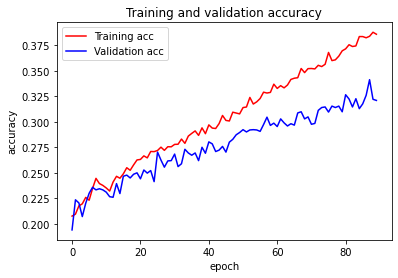

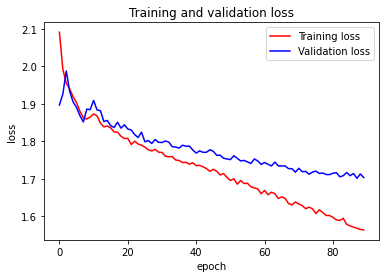

In [14]:
import matplotlib.pyplot as plt 

model.save('/content/drive/MyDrive/Fer2013_backup/checkpoint/Fix_Model_resnet50edit_SEED_SP1_90_noAug1.h5')

#ffd
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
num_epochs = range(len(accuracy))
plt.plot(num_epochs, accuracy, 'r', label='Training acc')
plt.plot(num_epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(num_epochs, loss, 'r', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
testloss = model.evaluate(xtest, ytest) 
print("Test Loss " + str(testloss[0]))
print("Test Acc: " + str(testloss[1]))
trainloss = model.evaluate(xtrain, ytrain) 
print("Train Loss " + str(trainloss[0]))
print("Train Acc: " + str(trainloss[1]))
vallosz = model.evaluate(x_val, y_val) 
print("val Loss " + str(vallosz[0]))
print("val Acc: " + str(vallosz[1]))

113/113 [==============================] - 3s 27ms/step - loss: 1.6973 - accuracy: 0.3344
Test Loss 1.6972860097885132
Test Acc: 0.334354966878891
898/898 [==============================] - 24s 27ms/step - loss: 1.5301 - accuracy: 0.4091
Train Loss 1.5301179885864258
Train Acc: 0.40907031297683716
113/113 [==============================] - 3s 27ms/step - loss: 1.7030 - accuracy: 0.3210
val Loss 1.7030404806137085
val Acc: 0.3209807872772217


In [16]:
from keras.models import load_model
model_load = load_model('/content/drive/MyDrive/Fer2013_backup/checkpoint/Fix_Model_resnet50edit_SEED_SP1_90_noAug1.h5')

model_load.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 46, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 46, 46, 8)    32          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [17]:
testloss = model_load.evaluate(xtest, ytest) 
print("Test Loss " + str(testloss[0]))
print("Test Acc: " + str(testloss[1]))

trainloss = model_load.evaluate(xtrain, ytrain) 
print("Train Loss " + str(trainloss[0]))
print("Train Acc: " + str(trainloss[1]))

vallosz = model_load.evaluate(x_val, y_val) 
print("val Loss " + str(vallosz[0]))
print("val Acc: " + str(vallosz[1]))

113/113 [==============================] - 7s 27ms/step - loss: 1.6973 - accuracy: 0.3344
Test Loss 1.6972860097885132
Test Acc: 0.334354966878891
898/898 [==============================] - 24s 27ms/step - loss: 1.5301 - accuracy: 0.4091
Train Loss 1.5301179885864258
Train Acc: 0.40907031297683716
113/113 [==============================] - 3s 27ms/step - loss: 1.7030 - accuracy: 0.3210
val Loss 1.7030404806137085
val Acc: 0.3209807872772217


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

#y_pred = model_load.predict(xtest)g

test_prob = model_load.predict(xtest)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == ytest)

print(test_accuracy)

0.33435497353023125


In [19]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


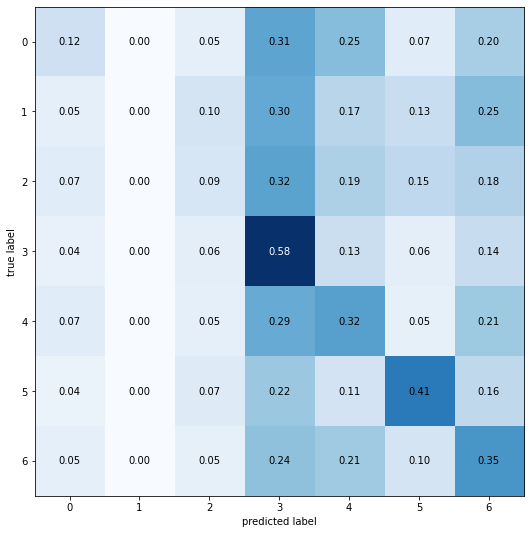

In [20]:
conf_mat = confusion_matrix(ytest, test_pred)
##
pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,show_normed=True,show_absolute=False,figsize=(9, 9))
fig.show()

In [21]:
print(classification_report(ytest, test_pred, target_names=emotions.values()))


              precision    recall  f1-score   support

       Angry       0.26      0.12      0.17       480
     Disgust       0.00      0.00      0.00        60
        Fear       0.22      0.09      0.13       515
       Happy       0.40      0.58      0.48       883
         Sad       0.27      0.32      0.29       597
    Surprise       0.38      0.41      0.40       397
     Neutral       0.31      0.35      0.33       657

    accuracy                           0.33      3589
   macro avg       0.26      0.27      0.26      3589
weighted avg       0.31      0.33      0.31      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
